# Emulator error

Notebook to look at the error returned on emulator predictions. For each emulator we train the emulator on all but one training point, then use that training point to test the prediction accuracy and precision. We test this on the redshift emulator for each redshift bin, and the complete set. We start off using no postprocessing rescalings.

In [1]:
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import cProfile
import emcee
import corner
import copy
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler
import data_MPGADGET
import z_emulator
import p1d_arxiv
import matplotlib
%matplotlib notebook

In [2]:
# Get redshift list for z
z_list=np.array([2.0,2.5,3.25,3.25,4.0])
data=data_MPGADGET.P1D_MPGADGET(z_list=z_list,filename="1024_mock_2.json")
zs=data.z

repo=os.environ['LYA_EMU_REPO']
skewers_label='Ns256_wM0.05'
#skewers_label=None
basedir=repo+"/p1d_emulator/sim_suites/emulator_256_28082019/"
#basedir=repo+"/p1d_emulator/sim_suites/emulator_256_15072019/"
p1d_label=None
undersample_z=1
paramList=["mF","sigT_Mpc","gamma","kF_Mpc","Delta2_p"]
max_arxiv_size=None
kmax_Mpc=8

#emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
#                               undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,z_max=4,
#                               verbose=False,paramList=paramList,train=True,emu_type="polyfit")

emu=z_emulator.ZEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="polyfit",z_list=z_list,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

test_k=np.logspace(10**emu.emulators[0].arxiv.data[0]["k_Mpc"][1],10**10,100)

Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
Training GP on 200 points


 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Optimised
Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
Training GP on 200 points
Optimised
Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
Training GP on 200 points
Optimised
Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
Training GP on 200 points
Optimised


 /home/chris/.local/lib/python3.5/site-packages/numpy/core/function_base.py:279: RuntimeWarning:overflow encountered in power


Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
Training GP on 199 points
Optimised
Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
Training GP on 199 points
Optimised
Nearest training point: 0.12798643010215735


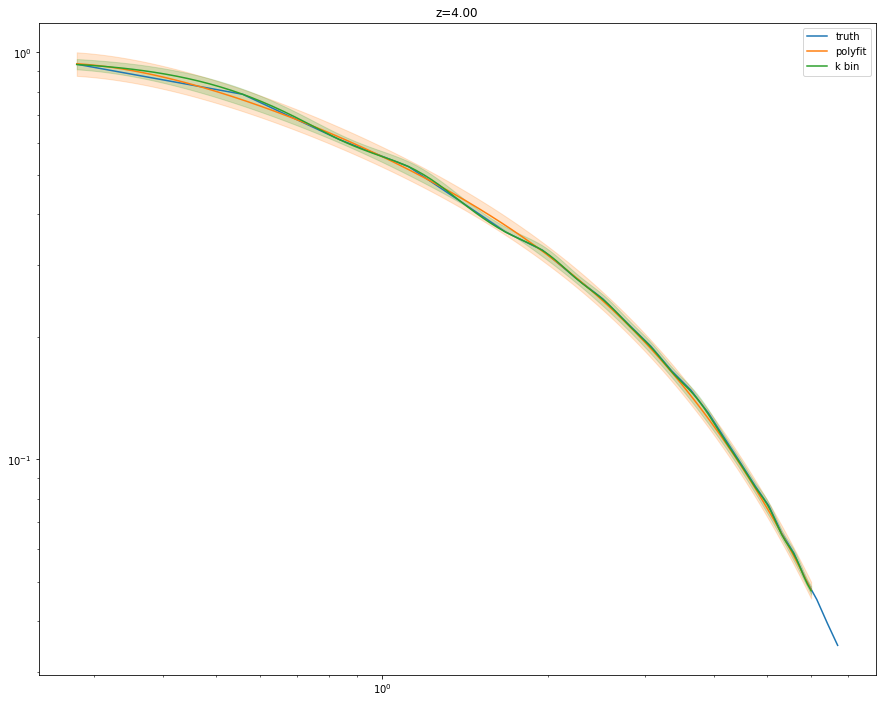

In [3]:
reduced_arxiv=copy.deepcopy(emu.emulators[0].arxiv)
test_point=reduced_arxiv.data.pop(np.random.randint(0,199))
test_k=np.logspace(np.log10(emu.emulators[0].arxiv.data[0]["k_Mpc"][1]),np.log10(6),200)

## Train new emulator with one missing point
emu_test_poly=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,passArxiv=reduced_arxiv,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="polyfit")
emu_test_k=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,passArxiv=reduced_arxiv,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin")


## Make predictions
pred_poly,covar_poly=emu_test_poly.emulate_p1d_Mpc(test_point,test_k,return_covar=True)
pred_k,covar_k=emu_test_k.emulate_p1d_Mpc(test_point,test_k,return_covar=True)

print("Nearest training point:", emu_test_k.get_nearest_distance(test_point))
## Plot
plt.figure(figsize=(15,12))
plt.title("z=%.2f" % emu_test_poly.arxiv.data[0]["z"])
plt.plot(test_point["k_Mpc"][1:25],test_point["p1d_Mpc"][1:25],label="truth")
plt.plot(test_k,pred_poly,label="polyfit",color="C1")
plt.fill_between(test_k,pred_poly+np.sqrt(np.diag(covar_poly)),pred_poly-np.sqrt(np.diag(covar_poly)),alpha=0.2,color="C1")
plt.plot(test_k,pred_k,label="k bin",color="C2")
plt.fill_between(test_k,pred_k+np.sqrt(np.diag(covar_k)),pred_poly-np.sqrt(np.diag(covar_k)),alpha=0.2,color="C2")
#plt.errorbar(test_k,pred_k,yerr=np.sqrt(np.diag(covar_k)),label="k bin")
plt.xscale("log")
plt.yscale("log")
plt.legend()

Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
Training GP on 199 points
Optimised
Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
Training GP on 199 points
Optimised
Nearest training point: 0.1046475259158787


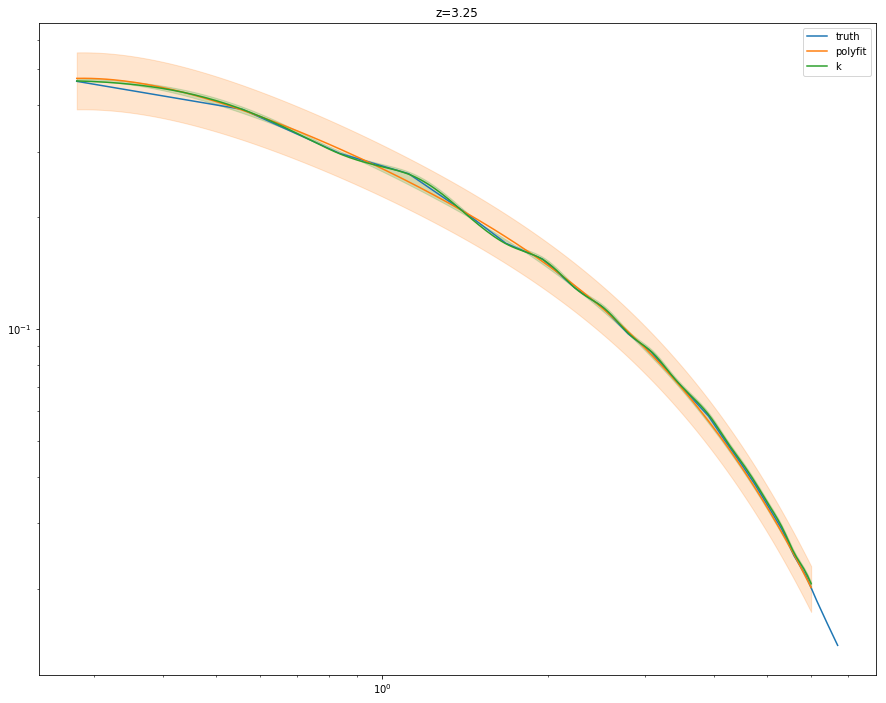

In [4]:
reduced_arxiv=copy.deepcopy(emu.emulators[1].arxiv)
test_point=reduced_arxiv.data.pop(np.random.randint(0,199))
test_k=np.logspace(np.log10(emu.emulators[0].arxiv.data[0]["k_Mpc"][1]),np.log10(6),200)

## Train new emulator with one missing point
emu_test_poly=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,passArxiv=reduced_arxiv,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="polyfit")
emu_test_k=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,passArxiv=reduced_arxiv,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin")

## Make predictions
pred_poly,covar_poly=emu_test_poly.emulate_p1d_Mpc(test_point,test_k,return_covar=True)
pred_k,covar_k=emu_test_k.emulate_p1d_Mpc(test_point,test_k,return_covar=True)

print("Nearest training point:", emu_test_k.get_nearest_distance(test_point))

## Plot
plt.figure(figsize=(15,12))
plt.title("z=%.2f" % emu_test_poly.arxiv.data[0]["z"])
plt.plot(test_point["k_Mpc"][1:25],test_point["p1d_Mpc"][1:25],label="truth")
plt.plot(test_k,pred_poly,label="polyfit",color="C1")
plt.fill_between(test_k,pred_poly+np.sqrt(np.diag(covar_poly)),pred_poly-np.sqrt(np.diag(covar_poly)),alpha=0.2,color="C1")
plt.plot(test_k,pred_k,label="k",color="C2")
plt.fill_between(test_k,pred_k+np.sqrt(np.diag(covar_k)),pred_poly-np.sqrt(np.diag(covar_k)),alpha=0.2,color="C2")
#plt.errorbar(test_k,pred_k,yerr=np.sqrt(np.diag(covar_k)),label="k bin")
plt.xscale("log")
plt.yscale("log")
plt.legend()

Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
Training GP on 199 points
Optimised
Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
Training GP on 199 points
Optimised
Nearest training point: 0.19292111840451975


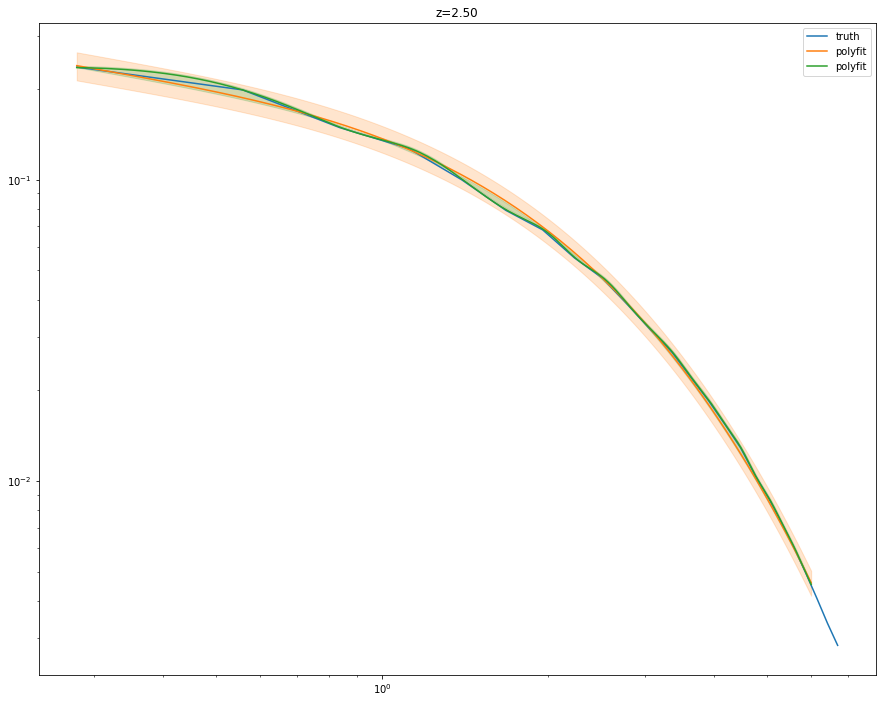

In [5]:
reduced_arxiv=copy.deepcopy(emu.emulators[2].arxiv)
test_point=reduced_arxiv.data.pop(np.random.randint(0,199))
test_k=np.logspace(np.log10(emu.emulators[0].arxiv.data[0]["k_Mpc"][1]),np.log10(6),200)

## Train new emulator with one missing point
emu_test_poly=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,passArxiv=reduced_arxiv,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="polyfit")
emu_test_k=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,passArxiv=reduced_arxiv,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin")

## Make predictions
pred_poly,covar_poly=emu_test_poly.emulate_p1d_Mpc(test_point,test_k,return_covar=True)
pred_k,covar_k=emu_test_k.emulate_p1d_Mpc(test_point,test_k,return_covar=True)

print("Nearest training point:", emu_test_k.get_nearest_distance(test_point))

## Plot
plt.figure(figsize=(15,12))
plt.title("z=%.2f" % emu_test_poly.arxiv.data[0]["z"])
plt.plot(test_point["k_Mpc"][1:25],test_point["p1d_Mpc"][1:25],label="truth")
plt.plot(test_k,pred_poly,label="polyfit",color="C1")
plt.fill_between(test_k,pred_poly+np.sqrt(np.diag(covar_poly)),pred_poly-np.sqrt(np.diag(covar_poly)),alpha=0.2,color="C1")
plt.plot(test_k,pred_k,label="polyfit",color="C2")
plt.fill_between(test_k,pred_k+np.sqrt(np.diag(covar_k)),pred_poly-np.sqrt(np.diag(covar_k)),alpha=0.2,color="C2")
#plt.errorbar(test_k,pred_k,yerr=np.sqrt(np.diag(covar_k)),label="k bin")
plt.xscale("log")
plt.yscale("log")
plt.legend()

Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
Training GP on 199 points
Optimised
Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
Training GP on 199 points
Optimised
Nearest training point: 0.1723985192547717


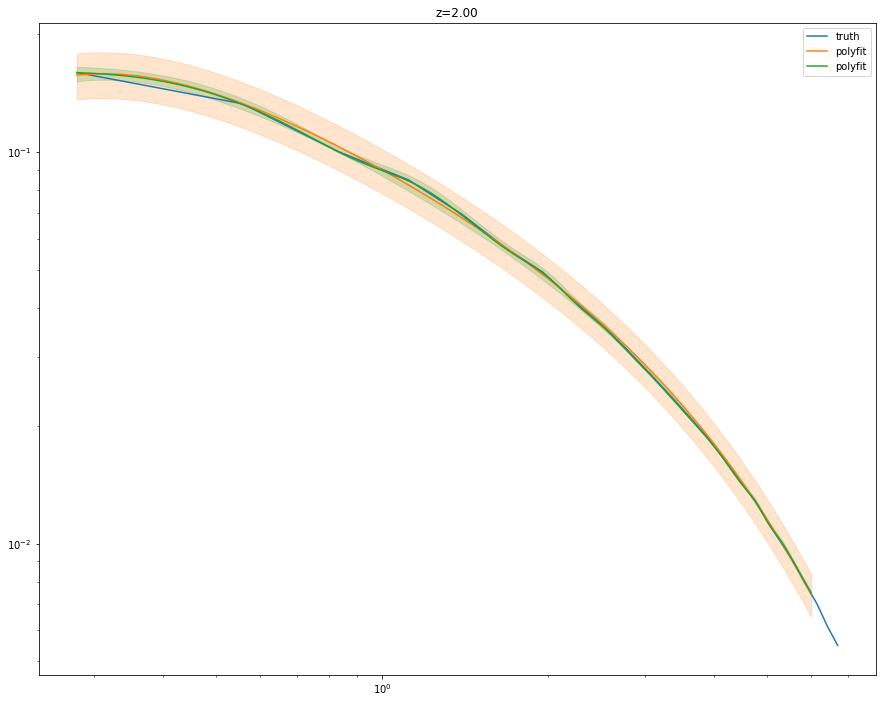

In [6]:
reduced_arxiv=copy.deepcopy(emu.emulators[3].arxiv)
test_point=reduced_arxiv.data.pop(np.random.randint(0,199))
test_k=np.logspace(np.log10(emu.emulators[0].arxiv.data[0]["k_Mpc"][1]),np.log10(6),200)

## Train new emulator with one missing point
emu_test_poly=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,passArxiv=reduced_arxiv,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="polyfit")
emu_test_k=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,passArxiv=reduced_arxiv,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin")

## Make predictions
pred_poly,covar_poly=emu_test_poly.emulate_p1d_Mpc(test_point,test_k,return_covar=True)
pred_k,covar_k=emu_test_k.emulate_p1d_Mpc(test_point,test_k,return_covar=True)

print("Nearest training point:", emu_test_k.get_nearest_distance(test_point))

## Plot
plt.figure(figsize=(15,12))
plt.title("z=%.2f" % emu_test_poly.arxiv.data[0]["z"])
plt.plot(test_point["k_Mpc"][1:25],test_point["p1d_Mpc"][1:25],label="truth")
plt.plot(test_k,pred_poly,label="polyfit",color="C1")
plt.fill_between(test_k,pred_poly+np.sqrt(np.diag(covar_poly)),pred_poly-np.sqrt(np.diag(covar_poly)),alpha=0.2,color="C1")
plt.plot(test_k,pred_k,label="polyfit",color="C2")
plt.fill_between(test_k,pred_k+np.sqrt(np.diag(covar_k)),pred_poly-np.sqrt(np.diag(covar_k)),alpha=0.2,color="C2")
#plt.errorbar(test_k,pred_k,yerr=np.sqrt(np.diag(covar_k)),label="k bin")
plt.xscale("log")
plt.yscale("log")
plt.legend()

### Full emulator

Now try do the same with the full 2000 model emulator (no postprocessings). Pop out 5 models and train on the remaining 1995.

In [7]:
full_emu_data=p1d_arxiv.ArxivP1D(basedir,p1d_label,skewers_label,drop_tau_rescalings=True,drop_temp_rescalings=True,z_max=4)

Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
Training GP on 1595 points
Optimised
Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
Training GP on 1595 points
Optimised
Nearest training point: 0.11755051484772792
Nearest training point: 0.053401762920986924
Nearest training point: 0.06538218898495954
Nearest training point: 0.04723154118057953
Nearest training point: 0.03772619062907359


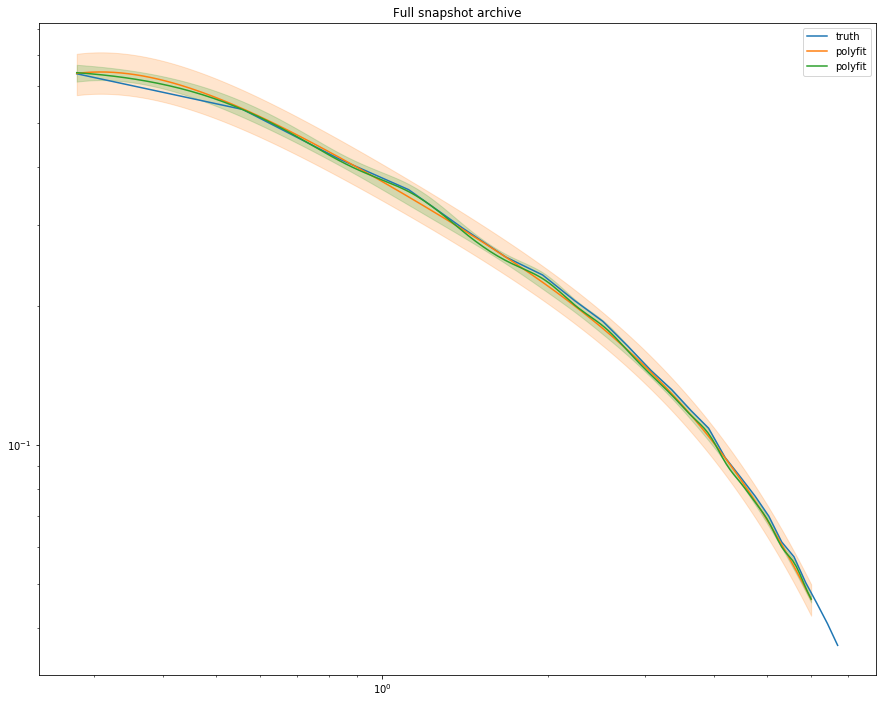

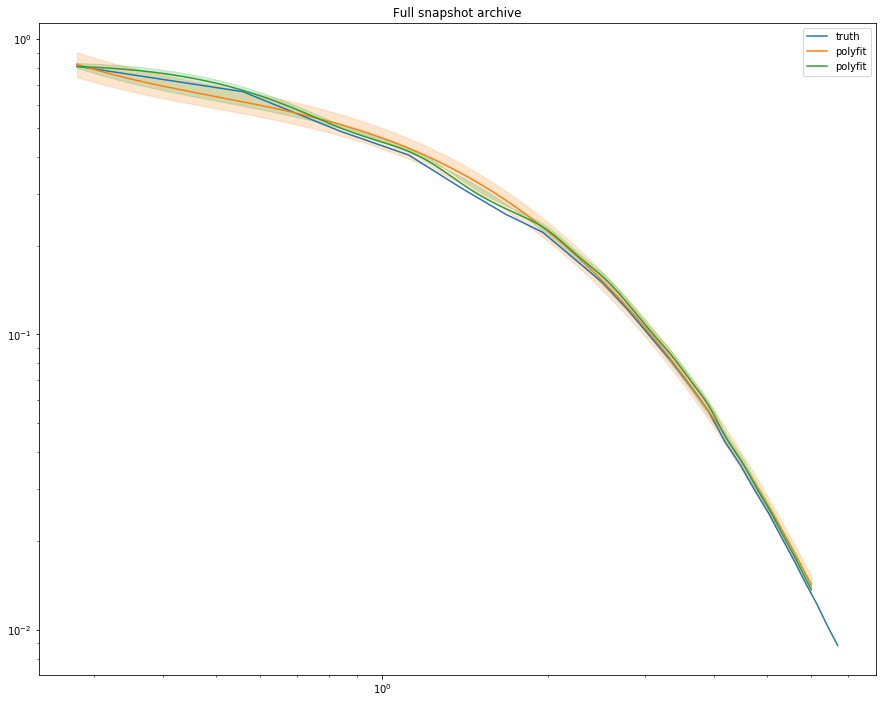

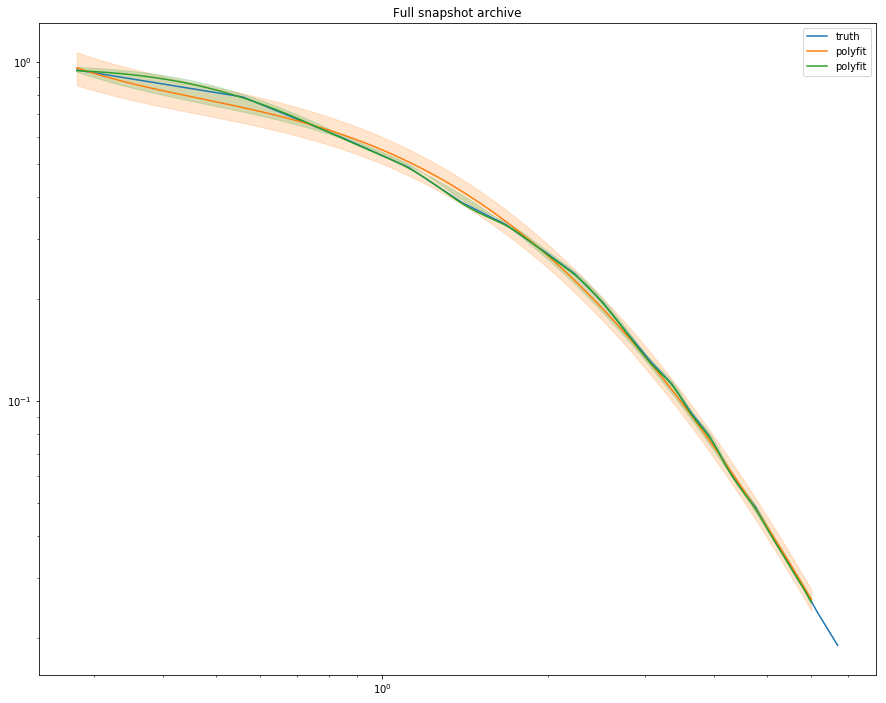

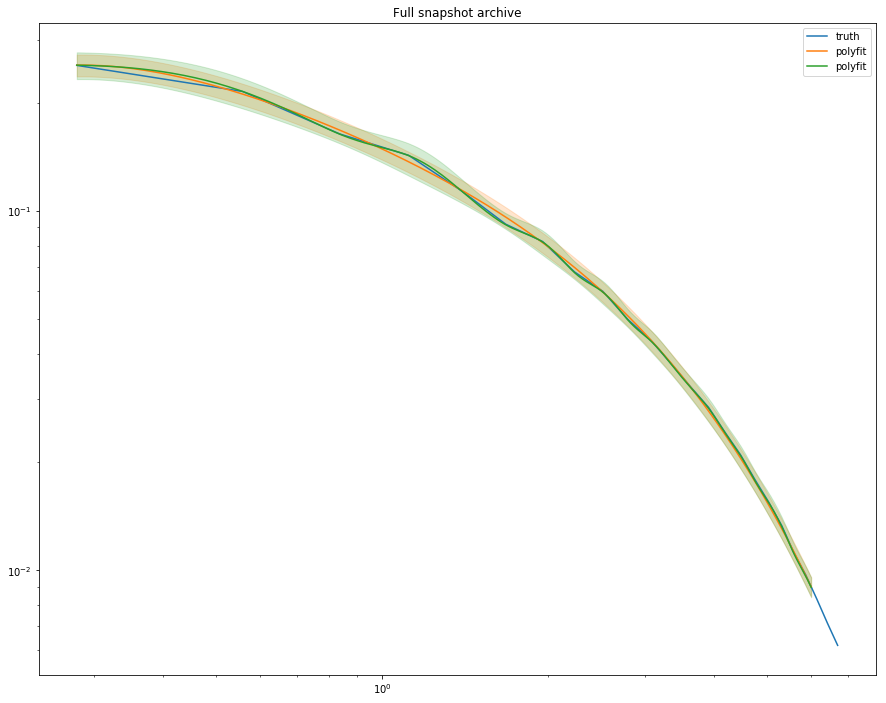

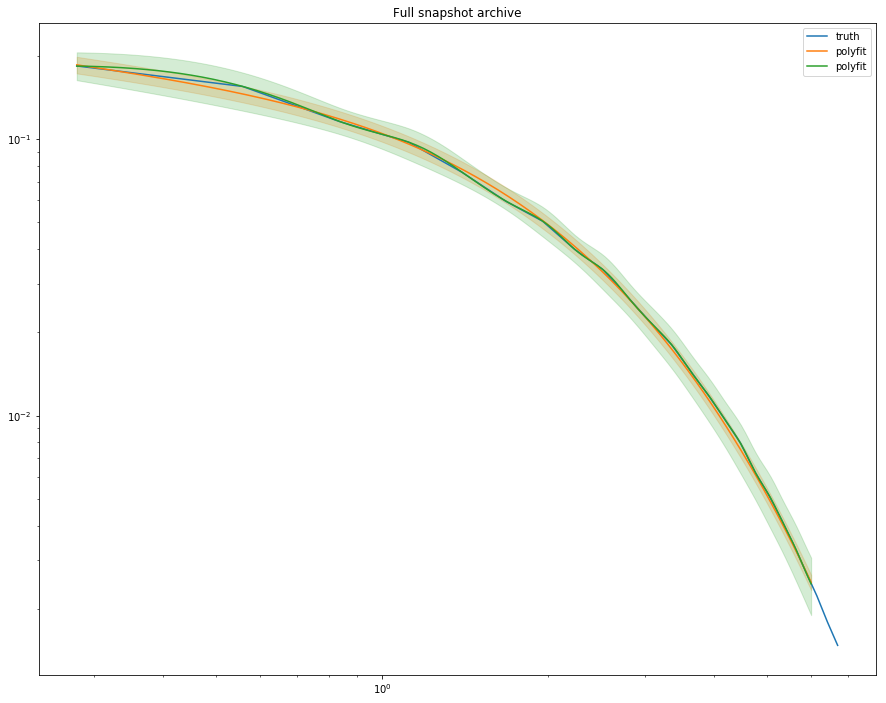

In [8]:
test_points=[]
num_test_points=5
for aa in range(num_test_points):
    test_points.append(full_emu_data.data.pop(np.random.randint(len(full_emu_data.data))))
test_k=np.logspace(np.log10(emu.emulators[0].arxiv.data[0]["k_Mpc"][1]),np.log10(6),200)

## Train new emulator with one missing point
emu_test_poly=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,passArxiv=full_emu_data,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="polyfit")
emu_test_k=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,passArxiv=full_emu_data,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin")

## Make predictions
for test_point in test_points:
    pred_poly,covar_poly=emu_test_poly.emulate_p1d_Mpc(test_point,test_k,return_covar=True)
    pred_k,covar_k=emu_test_k.emulate_p1d_Mpc(test_point,test_k,return_covar=True)
    print("Nearest training point:", emu_test_k.get_nearest_distance(test_point))
    ## Plot
    plt.figure(figsize=(15,12))
    plt.title("Full snapshot archive")
    plt.plot(test_point["k_Mpc"][1:25],test_point["p1d_Mpc"][1:25],label="truth")
    plt.plot(test_k,pred_poly,label="polyfit",color="C1")
    plt.fill_between(test_k,pred_poly+np.sqrt(np.diag(covar_poly)),pred_poly-np.sqrt(np.diag(covar_poly)),alpha=0.2,color="C1")
    plt.plot(test_k,pred_k,label="polyfit",color="C2")
    plt.fill_between(test_k,pred_k+np.sqrt(np.diag(covar_k)),pred_poly-np.sqrt(np.diag(covar_k)),alpha=0.2,color="C2")
    #plt.errorbar(test_k,pred_k,yerr=np.sqrt(np.diag(covar_k)),label="k bin")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()